# import library

In [76]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


In [78]:
# ดึงข้อมูลหุ้น SCC ตั้งแต่ปี 2010 ถึงปัจจุบัน
stock_symbol = "SCC.BK"
df = yf.download(stock_symbol, start="2010-01-01", end="2024-12-31")

# แสดงตัวอย่างข้อมูล
print(df.head())


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open   Volume
Ticker          SCC.BK      SCC.BK      SCC.BK      SCC.BK   SCC.BK
Date                                                               
2010-01-04  140.185410  141.990372  139.583755  141.990372   877400
2010-01-05  140.185410  141.990372  138.982101  141.388718  1117100
2010-01-06  138.380447  140.787064  137.778793  140.185410  1167600
2010-01-07  135.973846  138.982117  135.372192  138.982117  1832200
2010-01-08  136.575500  138.380463  135.372192  135.973846  2917000


# plot graph stock price 2010-2024

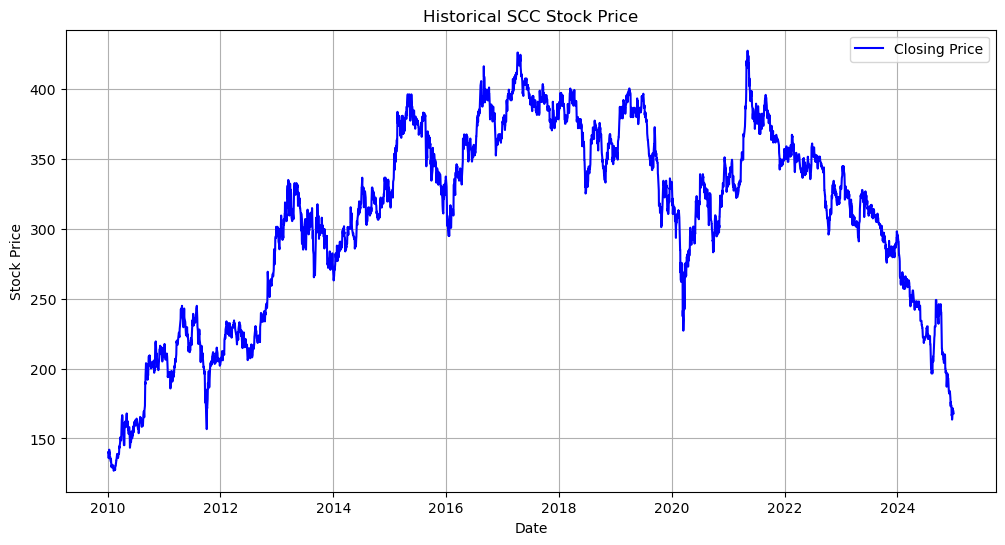

In [81]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label="Closing Price", color='blue')
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Historical SCC Stock Price")
plt.legend()
plt.grid()
plt.show()


In [82]:
df = df[['Close']]  # ใช้แค่ราคาปิด
df['Target'] = df['Close'].shift(-1)  # ทำนายราคาวันถัดไป
df.dropna(inplace=True)  # ลบค่า NaN

# แปลง index (วันที่) ให้เป็นตัวเลข
df['Date'] = df.index.map(pd.to_datetime)
df.reset_index(drop=True, inplace=True)


# แยกข้อมูล train & test

In [86]:
# แยกข้อมูล Train (ก่อนปี 2024) และ Test (ปี 2024)
df['Date'] = pd.to_datetime(df['Date'])  # แปลงให้เป็น datetime
train_data = df[df['Date'] < '2024-01-01']
test_data = df[df['Date'] >= '2024-01-01']

X_train, y_train = train_data[['Close']], train_data['Target']
X_test, y_test = test_data[['Close']], test_data['Target']


# ค่าความแม่นยำแต่ละโมเดล

In [89]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "XGBoost": XGBRegressor()
}

predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred

    # คำนวณค่าความแม่นยำ
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Model: {name}")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")
    print("-" * 50)


Model: Linear Regression
MAE: 2.4260, MSE: 13.9984, R2: 0.9829
--------------------------------------------------
Model: Decision Tree
MAE: 4.4434, MSE: 39.9880, R2: 0.9512
--------------------------------------------------
Model: Random Forest
MAE: 3.7369, MSE: 27.3193, R2: 0.9667
--------------------------------------------------
Model: XGBoost
MAE: 3.4810, MSE: 22.2403, R2: 0.9729
--------------------------------------------------


# พล็อตกราฟรวมทุกโมเดล

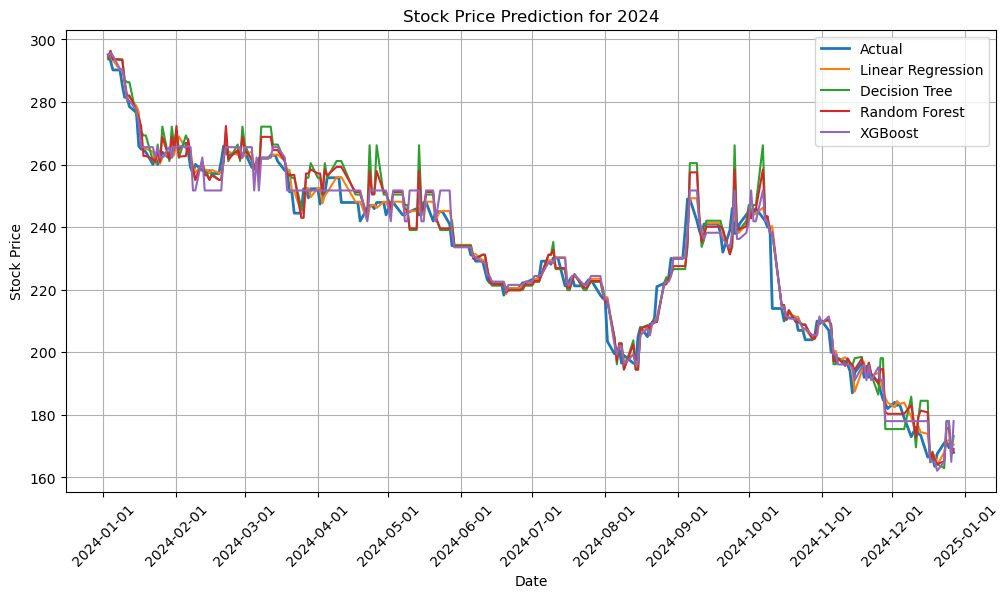

In [91]:
# สมมุติว่า test_data เป็น DataFrame ที่มีข้อมูลวันที่
# dates ควรจะเป็นวันที่ที่ตรงกับชุดข้อมูลทดสอบ
dates = test_data['Date']

# พล็อตกราฟรวมทุกโมเดลในหนึ่งกราฟ
plt.figure(figsize=(12,6))

# พล็อตข้อมูลจริง
plt.plot(dates, y_test, label="Actual", linewidth=2)

# พล็อตการทำนายจากแต่ละโมเดล
for name, y_pred in predictions.items():
    plt.plot(dates, y_pred, label=name)

# กำหนดรูปแบบวันที่
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# การตั้งค่าต่าง ๆ
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.legend()
plt.title("Stock Price Prediction for 2024")
plt.grid()

# แสดงกราฟ
plt.show()


# ค่าความแม่นยำแต่ละโมเดลเทียบเป็นเปอร์เซนต์

In [93]:
# ฟังก์ชันคำนวณ Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# คำนวณค่าความแม่นยำของแต่ละโมเดล
accuracy_scores = {}

for name, y_pred in predictions.items():
    mape = mean_absolute_percentage_error(y_test, y_pred)
    accuracy = 100 - mape  # เปลี่ยนจาก error เป็นเปอร์เซ็นต์ความแม่นยำ
    accuracy_scores[name] = accuracy

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.2f}%")
    print("-" * 50)


Model: Linear Regression
Accuracy: 98.92%
--------------------------------------------------
Model: Decision Tree
Accuracy: 98.03%
--------------------------------------------------
Model: Random Forest
Accuracy: 98.36%
--------------------------------------------------
Model: XGBoost
Accuracy: 98.46%
--------------------------------------------------


# predictive 2025

In [96]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


In [98]:
# ดึงข้อมูลหุ้น SCC ตั้งแต่ปี 2010 ถึงปัจจุบัน
stock_symbol = "SCC.BK"
df = yf.download(stock_symbol, start="2010-01-01", end="2024-12-31")

# แสดงตัวอย่างข้อมูล
print(df.head())


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open   Volume
Ticker          SCC.BK      SCC.BK      SCC.BK      SCC.BK   SCC.BK
Date                                                               
2010-01-04  140.185410  141.990372  139.583755  141.990372   877400
2010-01-05  140.185410  141.990372  138.982101  141.388718  1117100
2010-01-06  138.380447  140.787064  137.778793  140.185410  1167600
2010-01-07  135.973846  138.982117  135.372192  138.982117  1832200
2010-01-08  136.575500  138.380463  135.372192  135.973846  2917000


In [101]:
# ใช้เฉพาะราคาปิด (Close)
df = df[['Close']].copy()

# เพิ่ม Target ซึ่งเป็นราคาวันถัดไป
df['Target'] = df['Close'].shift(-1)

# แปลง index เป็นคอลัมน์ Date
df['Date'] = df.index

# ลบแถวที่มีค่า NaN
df.dropna(inplace=True)

# ตรวจสอบข้อมูล
print(df.head())


Price            Close      Target       Date
Ticker          SCC.BK                       
Date                                         
2010-01-04  140.185410  140.185410 2010-01-04
2010-01-05  140.185410  138.380447 2010-01-05
2010-01-06  138.380447  135.973846 2010-01-06
2010-01-07  135.973846  136.575500 2010-01-07
2010-01-08  136.575500  141.990402 2010-01-08


In [102]:
# ใช้ข้อมูลตั้งแต่ปี 2021 - 2024 เป็น Training Data
train_data = df[(df['Date'] >= '2021-01-01') & (df['Date'] < '2025-01-01')]

# แยก Features และ Target
X_train = train_data[['Close']]
y_train = train_data['Target']


In [104]:
# ตรวจสอบขนาดข้อมูล
print(f"Shape of X_train: {X_train.shape}")

# ถ้าไม่มีข้อมูล ให้แสดง Error
if X_train.shape[0] == 0:
    raise ValueError("X_train ว่างเปล่า! กรุณาตรวจสอบว่าดึงข้อมูลถูกต้อง")


Shape of X_train: (967, 1)


In [107]:
# สร้างและฝึกโมเดล
model = LinearRegression()
model.fit(X_train, y_train)

# ตรวจสอบค่าความแม่นยำ
y_train_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Linear Regression Model Trained!")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R2 Score: {r2:.4f}")


Linear Regression Model Trained!
MAE: 2.6213, MSE: 13.0901, R2 Score: 0.9957


In [109]:
# สร้างวันที่สำหรับปี 2025
future_dates = pd.date_range(start='2025-01-01', end='2025-12-31', freq='D')

# ใช้ราคาปิดสุดท้ายของปี 2024 เป็นจุดเริ่มต้น
last_price = X_train.iloc[-1, 0]
future_pred = []

for _ in range(len(future_dates)):
    pred = model.predict(np.array([[last_price]]))[0]  # ทำนายค่า
    future_pred.append(pred)
    last_price = pred  # ใช้ค่าที่พยากรณ์ไปเป็นข้อมูลวันถัดไป

# เก็บผลลัพธ์ใน DataFrame
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_pred})


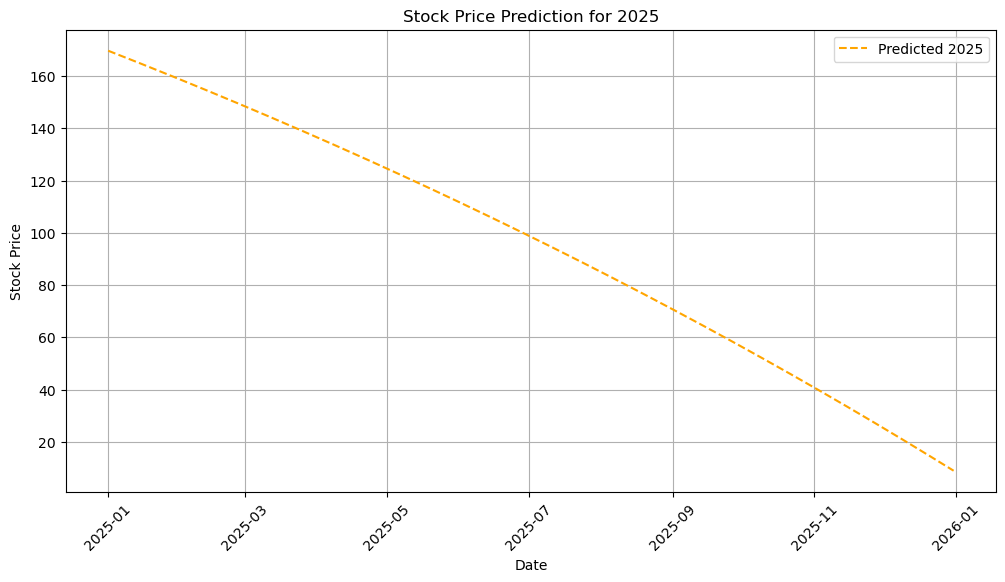

In [111]:
plt.figure(figsize=(12,6))

# พล็อตค่าพยากรณ์ปี 2025
plt.plot(future_df['Date'], future_df['Predicted_Close'], linestyle='dashed', color='orange', label="Predicted 2025")

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.legend()
plt.title("Stock Price Prediction for 2025")
plt.grid()
plt.show()


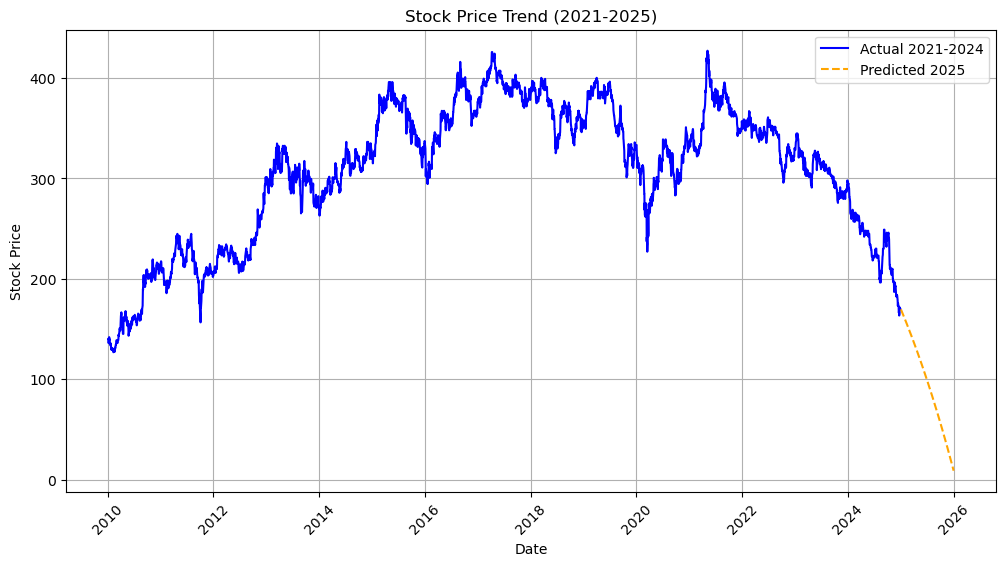

In [114]:
plt.figure(figsize=(12,6))

# พล็อตข้อมูลจริงปี 2021 - 2024
plt.plot(df[(df['Date'] >= '2010-01-01') & (df['Date'] < '2025-01-01')]['Date'],
         df[(df['Date'] >= '2010-01-01') & (df['Date'] < '2025-01-01')]['Close'], 
         color='blue', label="Actual 2021-2024")

# พล็อตค่าพยากรณ์ปี 2025
plt.plot(future_df['Date'], future_df['Predicted_Close'], linestyle='dashed', color='orange', label="Predicted 2025")

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.xticks(rotation=45)
plt.legend()
plt.title("Stock Price Trend (2021-2025)")
plt.grid()
plt.show()
